<a href="https://colab.research.google.com/github/marymlucas/obesity_lifestyle_diet/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project - Predict obesity of individuals based on diet and lifestyle habits

In [6]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [7]:
!wget https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz

--2022-03-06 14:58:37--  https://dlcdn.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220400553 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.3-bin-hadoop2.7.tgz’

spark-3.0.3-bin-had 100%[===================>] 210.19M   252MB/s    in 0.8s    

2022-03-06 14:58:38 (252 MB/s) - ‘spark-3.0.3-bin-hadoop2.7.tgz’ saved [220400553/220400553]



In [8]:
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

In [9]:
!pip install -q findspark

In [10]:
!pip install pyspark==3.0.3

     |████████████████████████████████| 209.1 MB 63 kB/s 
     |████████████████████████████████| 198 kB 61.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435971 sha256=129bae63ad949d20f988cc84eaca6cad4f2e46b3778d5c3c383d60d7d1fa6c14
  Stored in directory: /root/.cache/pip/wheels/7e/6d/0a/6b0bf301bc056d9af03194b732b9f49ad2fceb205aab2984fd
Successfully built pyspark


In [11]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.3-bin-hadoop2.7"

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from pyspark.sql import SparkSession

In [14]:
spark = SparkSession.builder.appName('DSCI632 - Final Project').getOrCreate()

In [15]:
import pandas as pd
import numpy as np

# Data Import and Exploration

In [16]:
raw_data = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/drive/MyDrive/Colab Notebooks/DSCI-632/project/data/ObesityDataSet_raw_and_data_sinthetic.csv')

In [17]:
raw_data.show(5)

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0|Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                         

In [18]:
# the data attributes and types are in the top part of the arff file
!pip install liac-arff

  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=0444d10de87f8b5e2a0abef41785d4af65d3ff34de61881a7c3ff81c5e2b6622
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff


In [19]:
import arff

with open('/content/drive/MyDrive/Colab Notebooks/DSCI-632/project/data/ObesityDataSet_raw_and_data_sinthetic.arff') as handle:
  data = arff.load(handle)

#print(data['attributes'])
for attribute in data['attributes']:
  print(attribute)

('Gender', ['Female', 'Male'])
('Age', 'NUMERIC')
('Height', 'NUMERIC')
('Weight', 'NUMERIC')
('family_history_with_overweight', ['yes', 'no'])
('FAVC', ['yes', 'no'])
('FCVC', 'NUMERIC')
('NCP', 'NUMERIC')
('CAEC', ['no', 'Sometimes', 'Frequently', 'Always'])
('SMOKE', ['yes', 'no'])
('CH2O', 'NUMERIC')
('SCC', ['yes', 'no'])
('FAF', 'NUMERIC')
('TUE', 'NUMERIC')
('CALC', ['no', 'Sometimes', 'Frequently', 'Always'])
('MTRANS', ['Automobile', 'Motorbike', 'Bike', 'Public_Transportation', 'Walking'])
('NObeyesdad', ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'])


According to Palechor and de la Hoz Manotas (2019), the attributes related with eating habits are: 
- Frequent consumption of high caloric food (FAVC) 
- Frequency of consumption of vegetables (FCVC) 
- Number of main meals (NCP)
- Consumption of food between meals (CAEC) 
- Consumption of water daily (CH20) 
- Consumption of alcohol (CALC)

The attributes related with the physical condition are: 
- Calories consumption monitoring (SCC) 
- Physical activity frequency (FAF) 
- Time using technology devices (TUE) 
- Transportation used (MTRANS)

Other variables included are: 
- Gender 
- Age
- Height
- Weight 

Finally, all data is labeled and the class variable NObesity has values: 
1. Insufficient Weight
2. Normal Weight
3. Overweight Level I
4. Overweight Level II
5. Obesity Type I
6. Obesity Type II and 
7. Obesity Type III 

based on the equation Mass Body Index = Weight / (weight * height) and information from WHO and Mexican Normativity. 

## EXPLORATORY DATA ANALYSIS

In [23]:
# Shape of data and missingness
print((raw_data.count(), len(raw_data.columns)))


(2111, 17)


In [24]:
# check for missing values
from pyspark.sql.functions import col,isnan, when, count
raw_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in raw_data.columns]).show()

+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC|FAF|TUE|CALC|MTRANS|NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|     0|  0|     0|     0|                             0|   0|   0|  0|   0|    0|   0|  0|  0|  0|   0|     0|         0|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+



We find that the data has no missing values so we don't need to worry about imputation.

Check the column types and fix any issues.  

In [25]:
raw_data.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- NObeyesdad: string (nullable = true)



From the description of the questions of the survey data (Table 1) in Palechor and de la Hoz Manotas (2019) we expect the all the attributes to be categorical except for age, height, and weight.
 
Let's check how many unique values are in each column.

In [30]:
from pyspark.sql.functions import countDistinct
raw_data.agg(*(countDistinct(col(c)).alias(c) for c in raw_data.columns)).show()


+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+----------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC| FAF| TUE|CALC|MTRANS|NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+----------+
|     2|1402|  1574|  1525|                             2|   2| 810|635|   4|    2|1268|  2|1190|1129|   4|     5|         7|
+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+----+----+----+------+----------+



Based on the number of unique values, this doesn't seem to be the case.  FCVC, NCP, CH2O, FAF, and TUE have too many values, and don't correspond to the "Possible Answers" expected in the survey per Table 1 in the paper. 

For example, for FAF (Physical activity frequency) the possible answers are supposed to be: "I do not have", '1 or 2 days', '2 or 4 days', '4 or 5 days'.  Therefore there should only be 4 distinct values in this column. But examining it shows:

In [68]:
raw_data.select('FAF').distinct().show()

+--------+
|     FAF|
+--------+
|1.967973|
|0.133398|
|0.462951|
| 1.97073|
|2.876696|
|1.416076|
|0.855973|
|1.018158|
|0.747528|
| 1.80674|
|1.917383|
|1.144076|
|0.886448|
| 0.06275|
|1.467863|
|0.019404|
|1.513029|
|0.178023|
|0.932792|
| 0.94522|
+--------+
only showing top 20 rows



In [69]:
# looking at all of them:
cols_to_check = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
for colName in cols_to_check:
  raw_data.select(colName).distinct().show(5)

+--------+
|    FCVC|
+--------+
| 2.39728|
|2.628791|
|1.220024|
| 2.55996|
|1.780746|
+--------+
only showing top 5 rows

+--------+
|     NCP|
+--------+
|2.581015|
|3.098399|
|2.964024|
|1.000414|
|2.228113|
+--------+
only showing top 5 rows

+--------+
|    CH2O|
+--------+
|2.566629|
|1.145761|
|2.721356|
|2.111913|
|1.753464|
+--------+
only showing top 5 rows

+--------+
|     FAF|
+--------+
|1.967973|
|0.133398|
|0.462951|
| 1.97073|
|2.876696|
+--------+
only showing top 5 rows

+--------+
|     TUE|
+--------+
|1.409198|
|0.786609|
|0.673408|
| 0.93648|
|0.101867|
+--------+
only showing top 5 rows



We will therefore treat these as numeric attributes.

####Exploring the Numeric Attributes:

Some basic statistics:

In [38]:
raw_data.toPandas().describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [126]:
numeric_attrs_df = raw_data[["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]]

# for doing the visualizations we will convert to pandas dataframe, this is better and more time-efficient than doing .collect()
numeric_pd_df = numeric_attrs_df.toPandas()

In [143]:
import matplotlib.pyplot as plt

def plot_dist(colName):
  x = numeric_pd_df[colName]
  minbin = min(numeric_pd_df[colName])
  maxbin = max(numeric_pd_df[colName])
  bin_step = (maxbin - minbin)/10
  bins = np.arange(minbin, maxbin, bin_step)

  plt.figure(figsize=(10,8))
  plt.hist(x, bins, alpha=0.8, histtype='bar')

  plt.xlabel(colName)
  plt.ylabel('Frequency')
  plt.xticks(bins)
  plt.show()

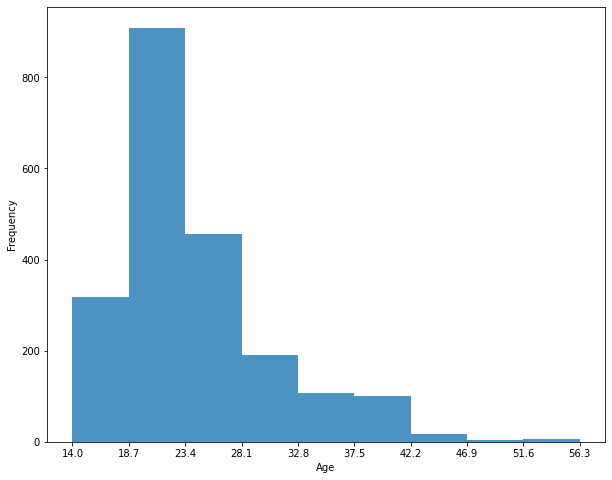

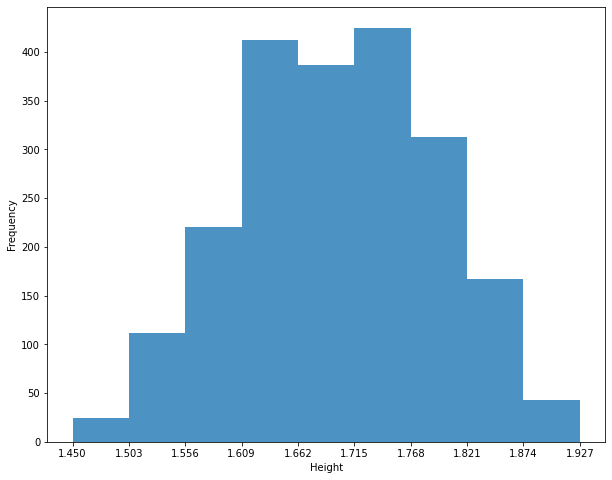

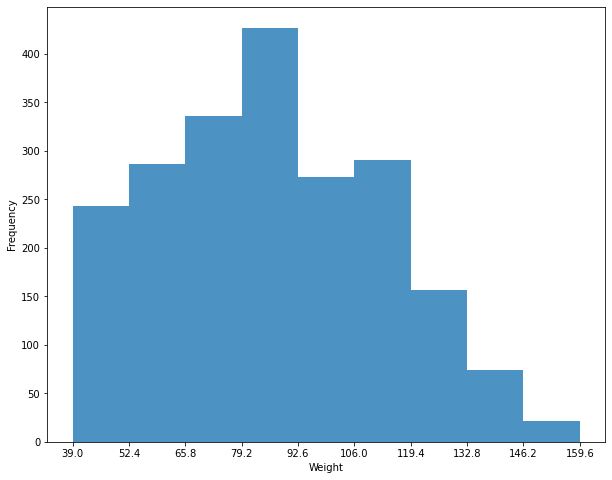

In [145]:
cols_to_plot = ["Age", "Height", "Weight"]

for colName in cols_to_plot:
  plot_dist(colName)

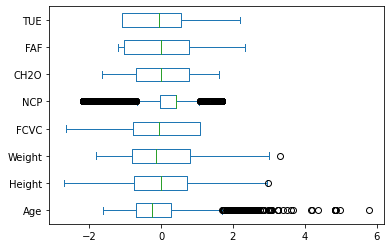

In [129]:
# let's check for outliers in the numerical attributes

normalized_data=(numeric_pd_df-numeric_pd_df.mean())/numeric_pd_df.std() #normalize the data to make it easier to visualize in one plot
normalized_data.plot(kind='box', vert=False)

We see some outliers for Age, Height, and Weight, but examining the data (max age 61, max height 1.98 meter, max weight 173kg) these are realistic values given normal age, height, and weight values in the population, so we won't do anything about it. NCP (Number of main meals) also has some outliers, but again looking at the data, the max NCP is 4 and the min is 1. These are also realistic and reasonable values so we will not do anything about them. 

Looking at the correlation matrix of numerical attributes.

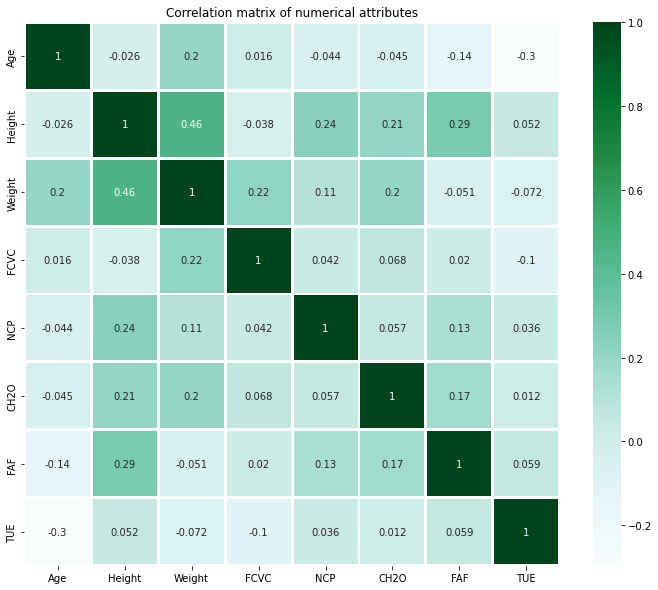

In [151]:
import seaborn as sns

data_corr = numeric_pd_df.corr()

plt.figure(figsize = (12, 10))
sns.heatmap(data_corr, annot = True, cbar=True, cmap="BuGn", linewidths = 2, linecolor = "white")
plt.title("Correlation matrix of numerical attributes")
plt.show()

It doesn't appear that there are any strong correlations between any of the numerical attributes.

####Exploring the Categorical Attributes:

Now we check the distinct values in the categorical attributes:

In [ ]:
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

for colName in cat_cols:
  raw_data.select(colName).distinct().show()


+------+
|Gender|
+------+
|Female|
|  Male|
+------+

+------------------------------+
|family_history_with_overweight|
+------------------------------+
|                            no|
|                           yes|
+------------------------------+

+----+
|FAVC|
+----+
|  no|
| yes|
+----+

+----------+
|      CAEC|
+----------+
| Sometimes|
|Frequently|
|        no|
|    Always|
+----------+

+-----+
|SMOKE|
+-----+
|   no|
|  yes|
+-----+

+---+
|SCC|
+---+
| no|
|yes|
+---+

+----------+
|      CALC|
+----------+
| Sometimes|
|Frequently|
|        no|
|    Always|
+----------+

+--------------------+
|              MTRANS|
+--------------------+
|                Bike|
|             Walking|
|          Automobile|
|           Motorbike|
|Public_Transporta...|
+--------------------+

+-------------------+
|         NObeyesdad|
+-------------------+
|   Obesity_Type_III|
| Overweight_Level_I|
|    Obesity_Type_II|
|Insufficient_Weight|
|Overweight_Level_II|
|      Normal_Weight|
|

Check if categorical values are balanced:

In [163]:
for colName in cat_cols:
  raw_data.groupby(colName).count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female| 1043|
|  Male| 1068|
+------+-----+

+------------------------------+-----+
|family_history_with_overweight|count|
+------------------------------+-----+
|                            no|  385|
|                           yes| 1726|
+------------------------------+-----+

+----+-----+
|FAVC|count|
+----+-----+
|  no|  245|
| yes| 1866|
+----+-----+

+----------+-----+
|      CAEC|count|
+----------+-----+
| Sometimes| 1765|
|Frequently|  242|
|        no|   51|
|    Always|   53|
+----------+-----+

+-----+-----+
|SMOKE|count|
+-----+-----+
|   no| 2067|
|  yes|   44|
+-----+-----+

+---+-----+
|SCC|count|
+---+-----+
| no| 2015|
|yes|   96|
+---+-----+

+----------+-----+
|      CALC|count|
+----------+-----+
| Sometimes| 1401|
|Frequently|   70|
|        no|  639|
|    Always|    1|
+----------+-----+

+--------------------+-----+
|              MTRANS|count|
+--------------------+-----+
|                Bike|    7|
|             W

In [153]:
for colName in cat_cols:
  raw_data.stat.crosstab(colName, "NObeyesdad").show()


+-----------------+-------------------+-------------+--------------+---------------+----------------+------------------+-------------------+
|Gender_NObeyesdad|Insufficient_Weight|Normal_Weight|Obesity_Type_I|Obesity_Type_II|Obesity_Type_III|Overweight_Level_I|Overweight_Level_II|
+-----------------+-------------------+-------------+--------------+---------------+----------------+------------------+-------------------+
|             Male|                 99|          146|           195|            295|               1|               145|                187|
|           Female|                173|          141|           156|              2|             323|               145|                103|
+-----------------+-------------------+-------------+--------------+---------------+----------------+------------------+-------------------+

+-----------------------------------------+-------------------+-------------+--------------+---------------+----------------+------------------+---------

Scatter plots to get a visual sense of the relationship of each variable to the target variable.

##PREDICTING LEVELS OF OBESITY

Using the SparkML library, I will try different ML models to compare their performance. Will also aim to understand which of the available factors contribute most to obesity.

I will primarily use classification methods but will also do one clustering approach for comparison. For classification, I will use Logistic Regression, Decision Tree, an ensemble approach (XGBoost), and a Naive Bayes implementation.  For clustering, I will use K-means.  One approach I was hoping to use is Support Vector Machine. However, our taget variable has more than 2 classes and LinearSVC in Spark ML supports binary classification. Therefore we cannot use use SVM approach with our data.

In summary, the methods I have chosen are:
- Logistic Regression
- Decision Tree
- Gradient Boosting (XGBoost)
- Naive Bayes
- K-means 

For each method I will evaluate the model using the usual metrics - accuracy, precision, recall, F1 score, and area under ROC curve. In addition, I will assess fit for each model.

The first step will be to build a pipeline for preprocessing the data.

#### Pipeline for Preprocessing the Data

In [192]:
from pyspark.ml import Pipeline
from pyspark.ml.base import Transformer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MaxAbsScaler


# prepare the lists of features
numeric_features = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
cat_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
cat_cols_ind = []
for colName in cat_features:
  cat_cols_ind.append(colName + "_index")

# Convert all categorical variables to integers and create dummy variables
indexer1 = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(raw_data) for column in cat_cols] 
indexer2 = [StringIndexer(inputCol='NObeyesdad', outputCol='label')]

stages = indexer1 + indexer2

# Assemble a feature vector
feature_cols = numeric_features + cat_cols_ind

stages.append(VectorAssembler(inputCols=feature_cols, outputCol='vectorized_features'))

# scale the vectorized features since the values are on different scales. 
# chosen to use MaxAbsScaler which rescales each feature to range [-1, 1] by dividing through the maximum absolute value in each feature. 
# It does not shift/center the data, and thus does not destroy any sparsity.

scaler = MaxAbsScaler(inputCol="vectorized_features", outputCol="features")
stages.append(scaler)
pipeline = Pipeline(stages=stages)


In [193]:
# apply pipeline to transform the data
data_transformed = pipeline.fit(raw_data).transform(raw_data)

In [194]:
# split the data into train, test
seed = 10  # set seed for reproducibility
trainDF, testDF = data_transformed.randomSplit([0.8,0.2],seed)

### Logistic Regression

In [242]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

# run crossvalidation to try to find the best model
lr = LogisticRegression(maxIter = 10,regParam=0.3, elasticNetParam=0.8) #multinomial logistic (softmax) regression with elastic net regularization

# assigning hyperparameters
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, np.linspace(0.3, 0.01, 10)) \
    .addGrid(lr.elasticNetParam, np.linspace(0.3, 0.8, 6)) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds= 5)  
cvModel_lr = crossval_lr.fit(trainDF)
best_model_lr = cvModel_lr.bestModel.summary

In [243]:
predictions_lr_on_train = cvModel_lr.transform(trainDF)
predictions_lr_on_test = cvModel_lr.transform(testDF)


In [244]:
#compare accuracy on both train and test datasets

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
 
bcEvaluator_on_train = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve on train dataset: {bcEvaluator_on_train.evaluate(predictions_lr_on_train)}")
 
mcEvaluator_on_train = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy on train dataset: {mcEvaluator_on_train.evaluate(predictions_lr_on_train)}")

bcEvaluator_on_test = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve on test dataset: {bcEvaluator_on_test.evaluate(predictions_lr_on_test)}")
 
mcEvaluator_on_test = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy on test dataset: {mcEvaluator_on_test.evaluate(predictions_lr_on_test)}")

Area under ROC curve on train dataset: 0.5094521878363126
Accuracy on train dataset: 0.4199881023200476
Area under ROC curve on test dataset: 0.5290601011708937
Accuracy on test dataset: 0.37906976744186044


In [245]:
# get confusion matrix
predictions_lr_on_test.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  4.0|       6.0|    1|
|  5.0|       1.0|    9|
|  5.0|       2.0|    9|
|  1.0|       1.0|   68|
|  3.0|       2.0|   20|
|  4.0|       2.0|   39|
|  0.0|       1.0|   34|
|  2.0|       2.0|   48|
|  3.0|       1.0|   22|
|  6.0|       6.0|   45|
|  5.0|       6.0|   33|
|  1.0|       2.0|    1|
|  0.0|       0.0|    2|
|  3.0|       6.0|   12|
|  0.0|       2.0|   45|
|  4.0|       0.0|    2|
|  3.0|       0.0|    5|
|  4.0|       1.0|   20|
|  6.0|       0.0|    6|
|  5.0|       0.0|    9|
+-----+----------+-----+



In [263]:
# confusion matrix
import pyspark.sql.functions as F

#important: need to cast to float type, and order by prediction
preds_and_labels = predictions_lr_on_test.select(['prediction', 'label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[ 2. 34. 45.  0.  0.  0.  0.]
 [ 0. 68.  1.  0.  0.  0.  0.]
 [ 0.  0. 48.  0.  0.  0.  0.]
 [ 5. 22. 20.  0.  0.  0. 12.]
 [ 2. 20. 39.  0.  0.  0.  1.]
 [ 9.  9.  9.  0.  0.  0. 33.]
 [ 6.  0.  0.  0.  0.  0. 45.]]


The Logistic Regression model did not perform well on this dataset. 

##Decision Tree

In [254]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType


In [235]:
trainDF_dt = trainDF.withColumnRenamed('label','labelIndex')
testDF_dt = testDF.withColumnRenamed('label','labelIndex')

dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
model_dt = dt.fit(trainDF_dt)


In [236]:
# test model on train and test data
predictions_dt_on_train = model_dt.transform(trainDF_dt)
predictions_dt_on_test = model_dt.transform(testDF_dt)


In [237]:
predictions_dt_on_train.select("prediction", "labelIndex").show(5)


+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       0.0|       0.0|
|       5.0|       5.0|
|       3.0|       3.0|
|       5.0|       5.0|
|       3.0|       3.0|
+----------+----------+
only showing top 5 rows



In [238]:
predictions_dt_on_test.select("prediction", "labelIndex").show(5)

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       5.0|       5.0|
|       5.0|       5.0|
|       5.0|       5.0|
|       3.0|       3.0|
|       3.0|       3.0|
+----------+----------+
only showing top 5 rows



In [249]:
evaluator = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction",metricName="accuracy")
accuracy_on_train = evaluator.evaluate(predictions_dt_on_train)
accuracy_on_test = evaluator.evaluate(predictions_dt_on_test)
print("Accuracy on Train = %g " % accuracy_on_train)
print("Accuracy on Test = %g " % accuracy_on_test)

Accuracy on Train = 0.837002 
Accuracy on Test = 0.827907 


In [262]:
# confusion matrix

preds_and_labels = predictions_dt_on_test.select(['prediction', 'labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[77.  0.  1.  2.  1.  0.  0.]
 [ 0. 68.  1.  0.  0.  0.  0.]
 [ 2.  0. 46.  0.  0.  0.  0.]
 [ 1.  0.  0. 36. 20.  2.  0.]
 [14.  0.  0.  2. 46.  0.  0.]
 [ 0.  0.  0. 14.  4. 38.  4.]
 [ 0.  0.  0.  0.  0.  6. 45.]]


We see that the Decision Tree classifier did well on our data with majority of the target variables being predicted correctly (diagonal)

###Gradient Boosted Tree Classifier

###Naive Bayes

###K-Means Clustering

###Model Comparisons

##Discussion

##Conclusion